In [1]:
import numpy as np
import numpy.linalg as nla
import scipy.linalg as sla
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('classic')
import seaborn as sns
import math
import time 

## No diffusion

In [2]:
def matrix_R(n, rh):
    """Defines the matrix R"""
    
    R = np.zeros((n,n),dtype=float)

    for i in range(n-1):
        R[i+1,i] = 1
        R[i+1,i+1] = -1
    R[0,0], R[n-1,n-1] = -rh, -rh

    return R

def vector_r(n, rc, rh, Tc, Th):
    """Defines the vector r"""
    
    r = np.zeros(n,dtype=float)
    r[0], r[-1] = rh*Th, rc*Tc
    
    return r

def jordan(n, rc):
    "Returns the Jordan transformation matrix P"
    
    P = np.zeros((n,n),dtype=float)
    
    # eigenvalue 1
    P[n-1,0] = 1
    for i in range(n-1):
        P[i,1] = np.power(-rc,n-2-i)
    
    # eigenvalue 2            
    for i in range(n-2):
        P[n-1-i,i+2] = 1
        P[n-2-i,i+2] = rc
        
    return P

def decomposition(J):
    """Splits the Jordan blocks"""
    
    J1 = J[:2,:2]
    J2 = J[2:,2:]
    
    d = [J1[0,0], J2[0,0]]
    n = [len(J1[0]), len(J2[0])]
    
    return [d,n]
    
def expN(n, x):
    """Returns the exponential of a nilpotent matrix"""
    
    eN = np.zeros((n,n),dtype=float)
    for i in range(n):
        entry = np.power(x,i)/math.factorial(i)*np.ones(n-i)
        eN += np.diag(entry,i)
    
    return eN

def recomposition(M1, M2):
    """Merge matrix blocks together"""
    
    n1, n2 = len(M1[0]), len(M2[0])
    n = n1+n2
    M = np.zeros((n,n),dtype=float)
    M[:n1,:n1] = M1
    M[n1:,n1:] = M2
    
    return M

def expA(at, P, PI, n, d):
    """Exponential of the matrix A"""    
    
    eN1 = expN(n[0],at)
    eN2 = expN(n[1],at)
    eN = recomposition(eN1,eN2)
    
    eD1 = np.ones(n[0])*np.exp(at*d[0])
    eD2 = np.ones(n[1])*np.exp(at*d[1])
    eD = np.concatenate((eD1,eD2))
    
    eA = nla.multi_dot([P,eN,np.diag(eD),PI])

    return eA
    

Final state: [70.         70.         70.         70.         70.         70.
 70.         70.         70.         70.         70.         70.
 70.         70.         70.         70.         70.         70.
 70.         36.66666667]
Iteration time: 0.0005063564777374268


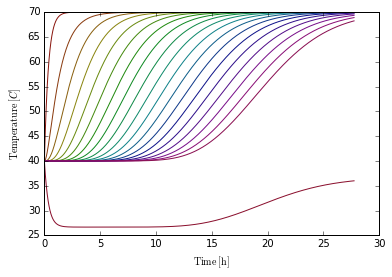

In [3]:
# parameters of the tank
n = 20 # number of layers
Th, Tc = 70., 20. # incoming temperatures
T0 = 40*np.ones(n,dtype=float) #initial temperature
rho = 1e3 # liquid density [kg/m^3]
L, rad = 2.5, 0.5 # height and radius of the cylinder [m]
V = L*np.pi*np.power(rad,2) # volume of the cylinder [m^3]
V = V/n # volume of a layer [m^3]
mh, mc = 0.075, 0.05 # incoming flux [kg/s]

# redefinition of parameters
ah, ac = mh/rho/V, mc/rho/V
a = ah-ac
rc, rh = ac/a, ah/a

# definition of matrices and vectors
r = vector_r(n,rc,rh,Tc,Th) # non-homogeneous vector
R = matrix_R(n,rh) # main matrix
RI = nla.inv(R)

P = jordan(n, rc) # Jordan transformation matrix
PI = nla.inv(P)
J = nla.multi_dot([PI,R,P]) # Jordan matrix
d, n = decomposition(J) # eigen values and multiplicities 

# solution
tmax, dt = 1e5, 1e2
t_tab = np.arange(0,tmax,dt)
nt = len(t_tab)
N = n[0]+n[1]
T = np.zeros((N,nt),dtype=float)

Tinf = -np.dot(RI,r) # final state
print('Final state: '+str(Tinf))

tic = time.time()
for it, t in enumerate(t_tab):
    eA = expA(a*t,P,PI,n,d)
    T[:,it] = np.dot(eA,T0-Tinf)+Tinf
tac = time.time()
print('Iteration time: '+str((tac-tic)/nt))

# plot 
color_set = sns.hls_palette(N, l=.3, s=.8)
fig, ax = plt.subplots()
for j in range(N):
    ax.plot(t_tab/60/60,T[j],Linestyle='-',color=color_set[j])
ax.set(xlabel='$\mathrm{Time}\:[\mathrm{h}]$',ylabel='$\mathrm{Temperature}\:[C]$')
plt.show()

## With diffusion

In [4]:
def matrix_A(n, a, ah, alpha):
    """Defines the matrix A"""

    A = np.zeros((n,n),dtype=float)

    for i in range(n-2):
        A[i+1,i] = a+alpha
        A[i+1,i+1] = -(a+2*alpha)
        A[i+1,i+2] = alpha
    A[0,0], A[0,1] = -(ah+alpha), alpha
    A[-1,-2], A[-1,-1] = a+alpha, -(ah+alpha)
    return A

def vector_b(n, ac, ah, Tc, Th):
    """Defines the vector b"""
    
    b = np.zeros(n,dtype=float)
    b[0], b[-1] = ah*Th, ac*Tc
    
    return b

def evolution(A, C, T0, dt, tmax):
    """Computes the time evolution"""

    k, O = nla.eig(A)
    OI = nla.inv(O)
    AI = nla.inv(A)
    expK = lambda t: np.diag(np.exp(k*t))
    expA = lambda t : nla.multi_dot([O,expK(t),OI])
    Tinf = -np.dot(AI,C)

    def func(t):
        eA = expA(t)
        return np.dot(eA,T0-Tinf)+Tinf

    t = np.arange(0,tmax,dt)
    n, N = len(t), len(T0)
    T = np.array([func(tp) for tp in t],dtype=float)

    return [t, np.transpose(T)]

Iteration time: 4.4556498527526855e-05


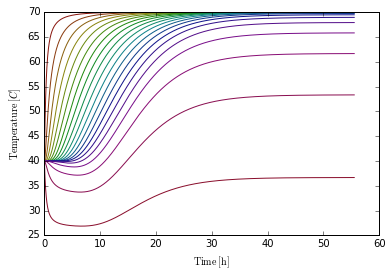

In [12]:
# parameters of the tank
n = 20 # number of layers
Th, Tc = 70., 20. # incoming temperatures
T0 = 40*np.ones(n,dtype=float) #initial temperature
rho = 1e3 # liquid density [kg/m^3]
L, rad = 2.5, 0.5 # height and radius of the cylinder [m]
V = L*np.pi*np.power(rad,2) # volume of the cylinder [m^3]
V = V/n # volume of a layer [m^3]
mh, mc = 0.075, 0.05 # incoming flux [kg/s]
c = 4000 # heat capacity [J/kg/K]
d = 1e2 # diffusion coefficient [W/K]

# redefinition of parameters
ah, ac = mh/rho/V, mc/rho/V
a = ah-ac
alpha = d/rho/c/V

# definition of matrices and vectors
b = vector_b(n,ac,ah,Tc,Th)
A = matrix_A(n,a,ah,alpha)

# solution
tmax, dt = 2*1e5, 1e2
tic = time.time()
t, T = evolution(A,b,T0,dt,tmax)
tac = time.time()
print('Iteration time: '+str((tac-tic)/len(t)))

# plots
N, n = T.shape
color_set = sns.hls_palette(N, l=.3, s=.8)
fig, ax = plt.subplots()
for j in range(N):
    ax.plot(t/60/60,T[j],Linestyle='-',color=color_set[j])
ax.set(xlabel='$\mathrm{Time}\:[\mathrm{h}]$',ylabel='$\mathrm{Temperature}\:[C]$')
plt.show()